## **Image Classification with MNIST Dataset**

In [60]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
from torch.utils.data import random_split, DataLoader


import torch.nn as nn
import torch.optim as optim

In [61]:

# Transform definition to convert images to tensors in pytorch
# The series of transformations is given as an order of steps in a list

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, ), (0.5, ))
    ]
)

In [62]:
# Download the dataset
mnist_data_train = torchvision.datasets.MNIST(root="./mnist", train = True, transform = transform, download = True)

# Load the dataset
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset = mnist_data_train, batch_size = batch_size, shuffle = True)

In [63]:
train_loader

Displaying the first image in the training set...


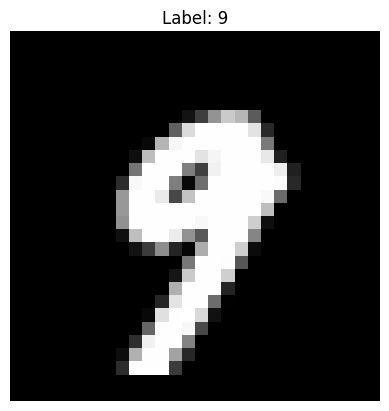

In [64]:
import matplotlib.pyplot as plt

def show_image(image, label):
    # Remove the channel dimension (1, 28, 28) -> (28, 28)
    image = image.squeeze()  
    plt.imshow(image, cmap='gray')
    
    plt.title(f"Label: {label}")
     # Turn off axis labels for better visualization
    plt.axis('off') 
    plt.show()

# Example: Display the first image from the train_loader
for images, labels in train_loader:
    print("Displaying the first image in the training set...")
    show_image(images[0], labels[0].item())
    break


In [65]:
# Download the test dataset
test_dataset = torchvision.datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)

# Split the test dataset into validation and test sets; split 50-50
valid_size = len(test_dataset) // 2 
test_size = len(test_dataset) - valid_size
valid_dataset, test_dataset = random_split(test_dataset, [valid_size, test_size])

# Create DataLoaders for validation and test sets
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Example: Inspect the number of samples in each split
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Validation set size: 5000
Test set size: 5000


In [66]:
# Neural Network 
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.model(x)
    

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MNISTClassifier().to(device)

# Set the loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

## Working of `nn.CrossEntropyLoss()`

- **Batch size** = 64

So, every time an iteration occurs in the following code, there will be **64 images** and corresponding labels.

The outputs will be of size **10 x 64**, where each image has **10 output values** (since we are working with 10 classes for classification).

### Just printing the first image's 10 outputs and corresponding labels:

I think the **`grad_fn = SelectBackward0>`** is selecting the value in the tensor with the highest score.

Apparently, **`grad_fn = SelectBackward0>`** selects the gradients of the first maximum values.

But how is it knowing that the corresponding label to that position is so and so?

It doesn’t directly "know" the corresponding label. The label index is provided through the **cross-entropy loss calculation**, where the label is used to select the correct class in the output tensor.

In the case of digit classification (like MNIST), the label index is the same as the position of the corresponding class, so the model can compute the gradient for that class during backpropagation.

**`SelectBackward0`** is used whenever there is an operation involving selecting elements from a tensor. In the context of classification tasks, it's often used when selecting the predicted class or its corresponding logit during loss calculation. However, this is not exclusive to classification tasks and can be used in any scenario where elements are selected from a tensor.


In [101]:

for images, labels in train_loader:
    outputs = model(images)
    
    print(criterion(model(images), labels))
    print(f"images: {outputs[0]}\n")
    print(f"labels: {labels[0]}\n\n")
    

tensor(0.0112, grad_fn=<NllLossBackward0>)
images: tensor([ 14.7418, -46.3122,  -2.7663, -14.0004, -26.0970, -17.3313, -11.1109,
        -15.8948, -24.0124,  -5.2010], grad_fn=<SelectBackward0>)

labels: 0


tensor(0.0067, grad_fn=<NllLossBackward0>)
images: tensor([ -7.6498,  -6.9790,   9.9571,   1.2602,  -9.0825,  -9.8023, -17.8596,
         -1.5196, -10.7190, -21.4844], grad_fn=<SelectBackward0>)

labels: 2


tensor(0.0068, grad_fn=<NllLossBackward0>)
images: tensor([-12.2217,  -4.9268,   6.5312,  -1.6443, -15.3871, -10.4031, -10.3556,
        -11.1722, -15.0675, -12.4374], grad_fn=<SelectBackward0>)

labels: 2


tensor(0.0359, grad_fn=<NllLossBackward0>)
images: tensor([ -5.3195,  -8.5437,  -5.4333,  -3.3702, -23.2655,   0.6553,  -1.5265,
        -17.1230,   6.4406,  -7.2996], grad_fn=<SelectBackward0>)

labels: 8


tensor(0.0225, grad_fn=<NllLossBackward0>)
images: tensor([-16.6970, -18.9881,  -8.8192,  -4.8269,  -5.6267,  -4.8581, -18.9310,
          0.0548,   0.6988,   6.1607], 

In [102]:
for params in model.parameters():
    print(len(params))

128
128
64
64
10
10


In [103]:
# Training

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for image_batch, label_batch in train_loader:
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        
        loss = criterion(outputs, label_batch)
        
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        
    print(f"Epoch: {epoch+1}/{num_epochs}   Train Loss: {running_loss/len(train_loader):.4f}\n")
        

Epoch: 1/10   Train Loss: 0.0465

Epoch: 2/10   Train Loss: 0.0439

Epoch: 3/10   Train Loss: 0.0447

Epoch: 4/10   Train Loss: 0.0421

Epoch: 5/10   Train Loss: 0.0402

Epoch: 6/10   Train Loss: 0.0426

Epoch: 7/10   Train Loss: 0.0389

Epoch: 8/10   Train Loss: 0.0387

Epoch: 9/10   Train Loss: 0.0384

Epoch: 10/10   Train Loss: 0.0397



## **Model Evaluation**

In [112]:
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        for label in labels:
            all_labels.append(label)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for predict in predicted:
            all_preds.append(predict)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 
print(f"Valid Accuracy: {100 * correct / total:.2f}%")

Valid Accuracy: 96.78%


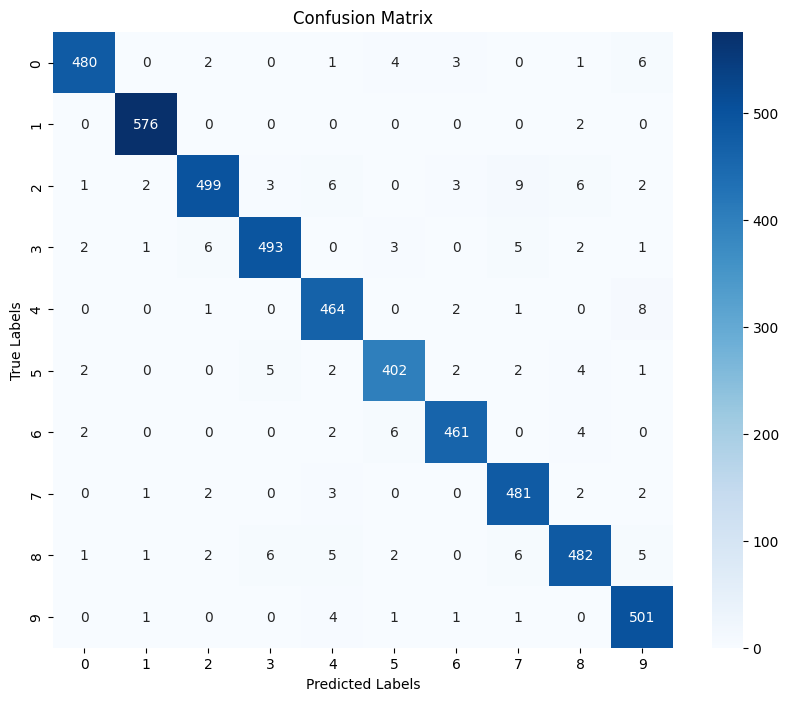

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


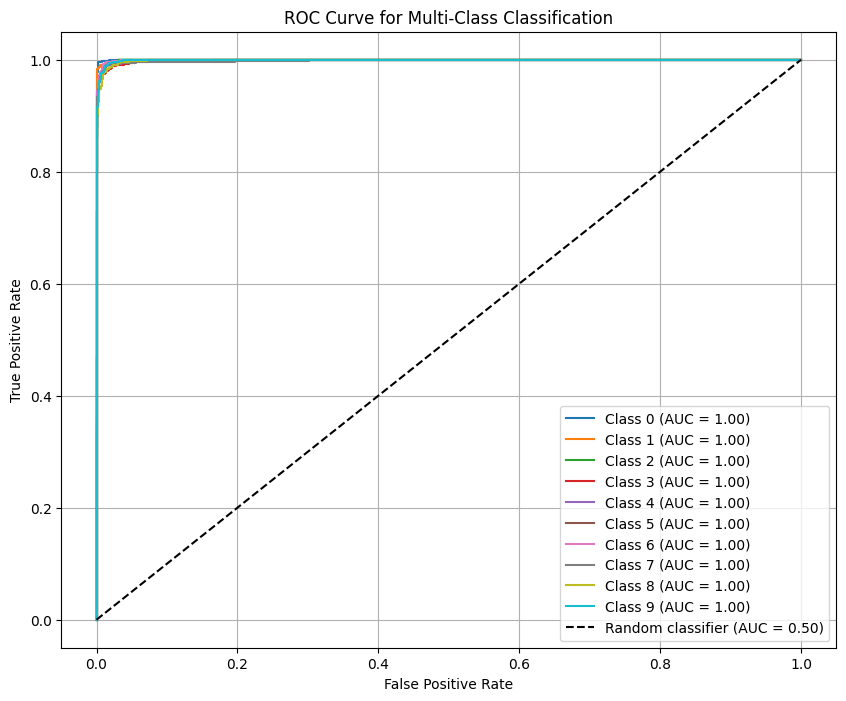

In [120]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
import numpy as np
from sklearn.preprocessing import label_binarize

# Initialize containers for all labels and predictions
all_labels = []
all_outputs = []

# Make sure model is in evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get model outputs (raw scores before applying softmax)
        outputs = model(images)
        
        # Apply softmax to get probabilities
        outputs = torch.softmax(outputs, dim=1).detach().cpu().numpy()

        # Collect all outputs and labels
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(outputs)

# Convert lists to numpy arrays
all_labels = np.concatenate(all_labels)
all_outputs = np.concatenate(all_outputs)

# Binarize the labels for multi-class ROC curve
n_classes = all_outputs.shape[1]
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plotting the diagonal line (random classifier line)
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUC = 0.50)')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


In [122]:
import plotly.graph_objects as go

# Create an empty list to store the ROC curve traces
roc_traces = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Create a plotly trace for each class
    trace = go.Scatter(
        x=fpr, y=tpr, mode='lines', name=f'Class {i} (AUC = {roc_auc:.2f})'
    )
    roc_traces.append(trace)

# Plotting the diagonal line (random classifier line)
random_line = go.Scatter(
    x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random classifier (AUC = 0.50)'
)

# Combine the traces
roc_traces.append(random_line)

# Create layout
layout = go.Layout(
    title="ROC Curve for Multi-Class Classification",
    xaxis=dict(title="False Positive Rate"),
    yaxis=dict(title="True Positive Rate"),
    showlegend=True
)

# Create the figure with all traces and layout
fig = go.Figure(data=roc_traces, layout=layout)

# Show the plot
fig.show()

In [115]:
import torch.nn.functional as F

log_loss = 0.0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        log_loss += loss.item()

log_loss /= len(test_loader)
print(f"Log-Loss: {log_loss:.4f}")


Log-Loss: 0.1412


In [117]:
def top_k_accuracy(outputs, labels, k=5):
    _, top_k_preds = torch.topk(outputs, k, dim=1)
    correct = top_k_preds.eq(labels.view(-1, 1).expand_as(top_k_preds))
    return correct.sum().item() / labels.size(0)

top_k_acc = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        top_k_acc += top_k_accuracy(outputs, labels, k=5)

top_k_acc /= len(test_loader)
print(f"Top-5 Accuracy: {top_k_acc:.2f}")


Top-5 Accuracy: 1.00


## Summary of Metrics:

- **Accuracy**: The fraction of correctly classified images.

- **Precision**: Measures the correctness of positive predictions.

- **Recall**: Measures the ability of the model to find all relevant positive samples.

- **F1-Score**: Balances precision and recall, useful in imbalanced datasets.

- **Confusion Matrix**: Shows the true vs predicted class distribution.

- **ROC-AUC**: Measures the ability to distinguish between classes.

- **Log-Loss**: Penalizes predictions based on the distance from the true label.

- **Top-k Accuracy**: Measures whether the true label is in the top k predictions.
